This notebook estimates parameters of a drift function by solving a linear least-squares problem.

Parameters are estimated using global satellite data and drifters velocities for the period 2010–2020:

- Geostrophic currents from DUACS (https://doi.org/10.48670/moi-00148),
- Stokes drift from WAVERYS/MFWAM (https://doi.org/10.48670/moi-00022),
- Wind stress and 10 m velocity from ERA5 (https://doi.org/10.48670/moi-00185),
- Drogued-SVP drifters from the GPD (https://doi.org/10.25921/x46c-3620).

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import cartopy.crs as ccrs
import cmocean.cm as cmo
from IPython.display import display, Math
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jaxopt
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr


from src.spherical_harmonics import gen_associated_legendre, sph_harm_y

In [18]:
gdp_ds = xr.open_zarr("data/gdp_interp.zarr")

# Problem overview

## 1. Original formulation from Rio *et al.* (2014)

The drift is modeled as:
$$
\vec{v}_d(\lambda, \phi) = \vec{u}_g(\lambda, \phi) + \beta(\lambda, \phi) \vec{\tau}(\lambda, \phi) e^{i \theta(\lambda, \phi)}
$$
where:

- $\vec{v}_d$ is the drifter velocity at the lat-lon point $(\lambda, \phi)$,
- $\vec{u}_g$ is the geostrophic current velocity,
- $\vec{\tau}$ is the wind stress at the ocean surface,
- $\beta$ and $\theta$ are the parameters of the empirical Ekman model.

$\beta$ and $\theta$ are subject to the following physical constraints: 
$$
\beta(\lambda, \phi) > 0, \ \forall (\lambda, \phi) \\
\theta(\lambda, \phi) \in [0, 2\pi], \ \forall (\lambda, \phi)
$$

## 2. Spatial dependency using spherical harmonics decompositions

In Rio **et al.**, $\beta$ and $\theta$ are fitted per spatial bins of 4° $\times$ 4°.
We propose to rather model their spatial dependency using spherical harmonics decompositions:
$$
\beta(\lambda, \phi) = \sum_l \sum_m \beta_m^l Y_m^l(\lambda, \phi) \\
\theta(\lambda, \phi) = \sum_l \sum_m \theta_m^l Y_m^l(\lambda, \phi)
$$

The resulting optimization problem is:
$$
\underset{\beta_m^l, \theta_m^l}{\operatorname{argmin}} \left \| \vec{v}_d(\lambda, \phi) - \vec{u}_g(\lambda, \phi) - \beta(\lambda, \phi) \vec{\tau}(\lambda, \phi) e^{i \theta(\lambda, \phi)} \right \|_2^2
$$
which is nonlinear and nonconvex.

## 3. Convex reformulation

Introducing the complex field:
$$
\alpha(\lambda, \phi) = \beta(\lambda, \phi) e^{i \theta(\lambda, \phi)}
$$
the problem becomes:
$$
\underset{\alpha_m^l}{\operatorname{argmin}} \left \| \vec{v}_d(\lambda, \phi) - \vec{u}_g(\lambda, \phi) - \alpha(\lambda, \phi) \vec{\tau}(\lambda, \phi) \right \|_2^2
$$,
where $\alpha(\lambda, \phi)$ is represented by a complex spherical harmonic decomposition:
$$
\alpha(\lambda, \phi) = \sum_l \sum_m \alpha_m^l Y_m^l(\lambda, \phi)
$$

This is a complex-valued least-squares problem, linear in the complex parameters $\alpha_m^l$.

The original $\beta$ and $\theta$ parameters of the empirical model of Rio *et al.* are recovered as:
$$
\beta = |\alpha| \\
\theta = arg(\alpha)
$$
which automatically satisfy the original constraints.

## 4. Computational challenge and optimization strategy

At the global scale, 10 years of data correspond to approximately about 20 million observations.
A direct least-squares solution would require materializing a dense design matrix of size 20M $\times$ 1k, which is prohibitive in memory ($\approx$ 500GB in complex128).

In anticipation of more physically and/or statistically elaborated (possibly nonlinear) models, we therefore recast the problem as a minibatch optimization problem, rather than relying on spatial binning.

Defining:
$$
\vec{x_i} = (\lambda_i, \phi_i, \vec{\tau}(\lambda_i, \phi_i)) \\
\vec{y_i} = \vec{v}_d(\lambda_i, \phi_i) - \vec{u}_g(\lambda_i, \phi_i)
$$
and the forward model:
$$
f_\alpha(\vec{x}) = \vec{\tau}(\lambda_i, \phi_i) \sum_l \sum_m \alpha_m^l Y_m^l(\lambda_i, \phi_i)
$$
we minimize the empirical risk:
$$
\mathcal{L}(\alpha) = \frac{1}{N} \sum_{i=1}^N \frac{1}{2} \left \| \vec{y_i} - f_\alpha(\vec{x_i}) \right \|^2_2
$$
The minimization is performed using gradient-based optimizers.

# Implementation

In [19]:
total_points = gdp_ds.points.size

x_full = (
    jnp.asarray(gdp_ds.lat.values), 
    jnp.asarray(gdp_ds.lon.values),
    jnp.asarray((gdp_ds.eastward_stress + 1j * gdp_ds.northward_stress).values)
)

u_drifters = jnp.asarray(gdp_ds.ve + 1j * gdp_ds.vn, dtype=jnp.complex128)
u_geos = jnp.asarray(gdp_ds.ugos + 1j * gdp_ds.vgos, dtype=jnp.complex128)

y_full = u_drifters - u_geos

## 2. Spherical harmonics decomposition

In [20]:
# Spherical harmonics setup

lmax_beta = 8
lmax_theta = 8

n_coeffs_beta = (lmax_beta + 1) ** 2
n_coeffs_theta = (lmax_theta + 1) ** 2

idx_beta = jnp.arange(n_coeffs_beta)
L_beta = jnp.repeat(jnp.arange(lmax_beta + 1), 2 * jnp.arange(lmax_beta + 1) + 1)
M_beta = idx_beta - L_beta * (L_beta + 1)

idx_theta = jnp.arange(n_coeffs_theta)
L_theta = jnp.repeat(jnp.arange(lmax_theta + 1), 2 * jnp.arange(lmax_theta + 1) + 1)
M_theta = idx_theta - L_theta * (L_theta + 1)


def get_beta_theta_bases(lat, lon):
    lat = jnp.deg2rad(lat)
    lon = jnp.deg2rad(lon)
    colat = jnp.pi / 2 - lat
    phi = lon % (2 * jnp.pi)

    legendre_beta = gen_associated_legendre(lmax_beta, colat, is_normalized=True)
    legendre_theta = gen_associated_legendre(lmax_theta, colat, is_normalized=True)

    Y_beta = jax.vmap(
        lambda l, m: sph_harm_y(l, m, colat, phi, n_max=lmax_beta, legendre=legendre_beta)
    )(L_beta, M_beta).T
    Y_theta = jax.vmap(
        lambda l, m: sph_harm_y(l, m, colat, phi, n_max=lmax_theta, legendre=legendre_theta)
    )(L_theta, M_theta).T

    return Y_beta, Y_theta

In [ ]:
# Loss function: mean squared error + regularization

batch_size = 500_000
beta_bg = 0.25  # background value for beta (climatology from Rio et al. 2014)
theta_bg = jnp.deg2rad(48.0)  # background value for theta (climatology from Rio et al. 2014)


def residual_fun(beta_coeffs, theta_coeffs, lat, lon, tau, y):
    def process_batch(carry, from_idx):
        lat_batch = jax.lax.dynamic_slice_in_dim(lat, from_idx, batch_size)
        lon_batch = jax.lax.dynamic_slice_in_dim(lon, from_idx, batch_size)
        tau_batch = jax.lax.dynamic_slice_in_dim(tau, from_idx, batch_size)
        y_batch = jax.lax.dynamic_slice_in_dim(y, from_idx, batch_size)

        Y_beta, Y_theta = get_beta_theta_bases(lat_batch, lon_batch)

        beta_batch = beta_bg + (Y_beta @ beta_coeffs).real
        theta_bg_batch = jnp.where(lat_batch > 0, -theta_bg, theta_bg)
        theta_batch = theta_bg_batch + (Y_theta @ theta_coeffs).real

        alpha_batch = beta_batch * jnp.exp(1j * theta_batch)
        pred_batch = alpha_batch * tau_batch

        residual_batch = jnp.abs(y_batch - pred_batch) ** 2

        carry = jax.lax.dynamic_update_slice_in_dim(carry, residual_batch, from_idx, axis=0)
        return carry, None

    n_batches = (y.size + batch_size - 1) // batch_size
    batches_idx = jnp.arange(n_batches) * batch_size

    residuals, _ = jax.lax.scan(process_batch, jnp.zeros_like(y, dtype=jnp.float64), batches_idx)

    return residuals


lambda_reg_beta = 1e-5
lambda_reg_theta = 1e-4

deg_norm_beta = 2 * L_beta + 1
deg_norm_theta = 2 * L_theta + 1

reg_weight_beta = L_beta * (L_beta + 1) / deg_norm_beta
reg_weight_theta = L_theta * (L_theta + 1) / deg_norm_theta


def loss_fun(params, args):
    beta_coeffs, theta_coeffs = params
    (lat, lon, tau), y = args

    residuals = residual_fun(beta_coeffs, theta_coeffs, lat, lon, tau, y)

    # latitude-weighted mean squared error
    weight = jnp.cos(jnp.deg2rad(lat))
    loss = jnp.sum(residuals * weight) / jnp.sum(weight)

    # degree-dependent regularization
    reg_beta = lambda_reg_beta * jnp.sum(reg_weight_beta * beta_coeffs**2)
    reg_theta = lambda_reg_theta * jnp.sum(reg_weight_theta * theta_coeffs**2)
    loss += reg_beta + reg_theta

    return loss


val_grad_loss_fun = jax.jit(jax.value_and_grad(loss_fun))

In [22]:
# Do optimization

beta_init = jnp.ones((n_coeffs_beta,))
# initializing theta to zero might help convergence as the problem is linear when theta=0
theta_init = jnp.zeros((n_coeffs_theta,))

solver = jaxopt.LBFGS(fun=val_grad_loss_fun, value_and_grad=True, maxiter=2_000)
sol = solver.run(init_params=(beta_init, theta_init), args=(x_full, y_full))

/home/bertrava/.local/share/mamba/envs/pastax_global_calibration/lib/python3.11/site-packages/jax/_src/lax/lax.py:5473: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


In [23]:
print(f"Solve took {sol.state.iter_num} iterations")

Solve took 11 iterations


In [24]:
betas_fit, thetas_fit = sol.params

In [25]:
alpha_rio2014_da = xr.open_zarr("data/rio_2014/alpha.zarr")["__xarray_dataarray_variable__"]  # for comparison

beta_rio2014_da = xr.DataArray(
    jnp.abs(alpha_rio2014_da.values),
    coords=alpha_rio2014_da.coords,
    dims=alpha_rio2014_da.dims,
)
theta_rio2014_da = xr.DataArray(
    jnp.angle(alpha_rio2014_da.values, deg=True),
    coords=alpha_rio2014_da.coords,
    dims=alpha_rio2014_da.dims,
)

In [26]:
global_lat = alpha_rio2014_da.lat.values
global_lon = alpha_rio2014_da.lon.values

global_lat2d, global_lon2d = jnp.meshgrid(global_lat, global_lon, indexing="ij")

In [27]:
global_lat_flat = global_lat2d.ravel()
global_lon_flat = global_lon2d.ravel()

global_Y_beta, global_Y_theta = get_beta_theta_bases(global_lat_flat, global_lon_flat)

In [28]:
global_beta = (global_Y_beta @ betas_fit).real
global_theta = (global_Y_theta @ thetas_fit).real

global_beta = global_beta.reshape(alpha_rio2014_da.shape)
global_theta = global_theta.reshape(alpha_rio2014_da.shape)

global_beta += beta_bg
global_theta += jnp.where(global_lat2d > 0, -theta_bg, theta_bg)

In [29]:
beta_fit_da = xr.DataArray(global_beta, coords=alpha_rio2014_da.coords, dims=alpha_rio2014_da.dims)
theta_fit_da = xr.DataArray(jnp.rad2deg(global_theta), coords=alpha_rio2014_da.coords, dims=alpha_rio2014_da.dims)

In [30]:
beta_fit_m_da = beta_fit_da * ~np.isnan(beta_rio2014_da)
theta_fit_m_da = theta_fit_da * ~np.isnan(theta_rio2014_da)

In [31]:
display(Math(
    r"\beta_e = {:.2f} \,\text{{m}}^2\text{{s}}/\text{{kg}}, \, \theta_e = {:.2f} \,\degree".format(
        beta_fit_m_da.mean().item(), np.abs(theta_fit_m_da).mean().item()
    )
))

<IPython.core.display.Math object>

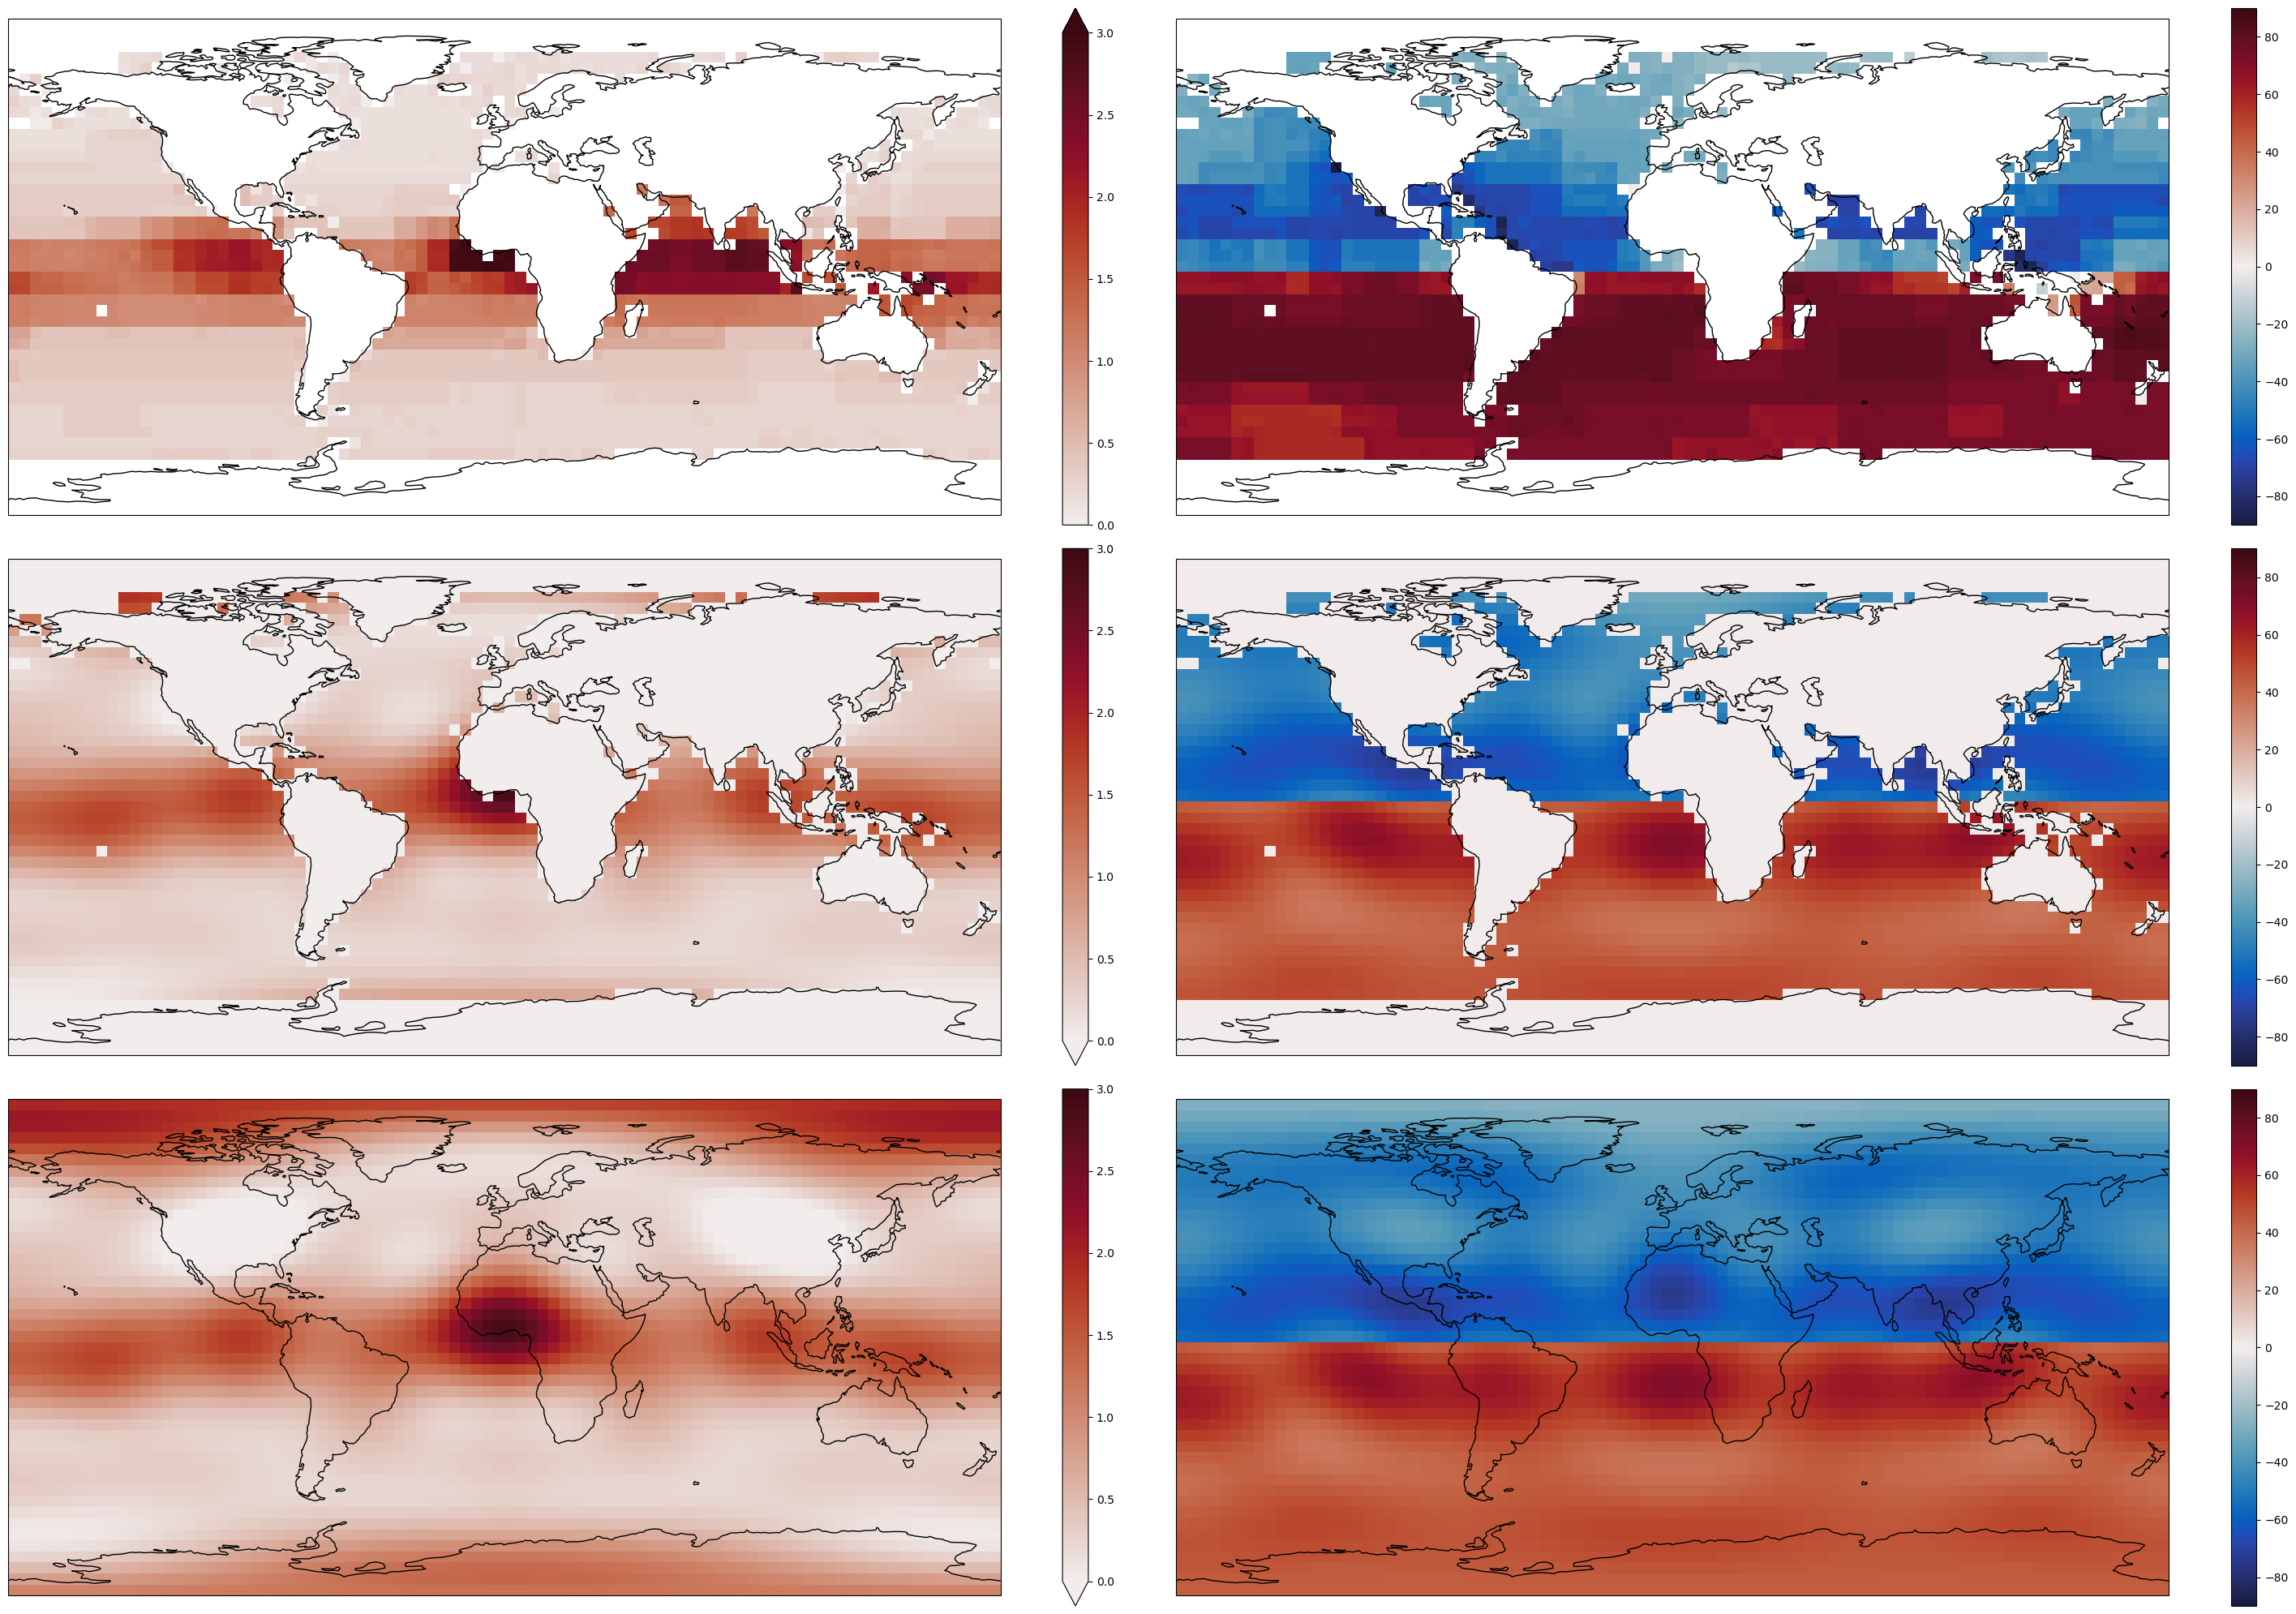

In [32]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(
    3, 2, figsize=(30, 20), subplot_kw={"projection": ccrs.PlateCarree()}
)

beta_rio2014_da.plot(ax=ax1, cmap=cmo.amp, vmin=0, vmax=3)
ax1.coastlines()

theta_rio2014_da.plot(ax=ax2, cmap=cmo.balance, vmin=-90, vmax=90)
ax2.coastlines()

beta_fit_m_da.plot(ax=ax3, cmap=cmo.amp, vmin=0, vmax=3)
ax3.coastlines()

theta_fit_m_da.plot(ax=ax4, cmap=cmo.balance, vmin=-90, vmax=90)
ax4.coastlines()

beta_fit_da.plot(ax=ax5, cmap=cmo.amp, vmin=0, vmax=3)
ax5.coastlines()

theta_fit_da.plot(ax=ax6, cmap=cmo.balance, vmin=-90, vmax=90)
ax6.coastlines()

fig.tight_layout()
plt.show()